In [1]:
!pip install protobuf==4.23.4 --force-reinstall --no-deps -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoFeatureExtractor, ASTForAudioClassification
import torch.nn as nn


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

2025-12-05 21:26:16.335976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764969976.553993      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764969976.618995      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# LOAD FMA METADATA

print("Loading metadata...")

tracks = pd.read_csv(
    "/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv",
    index_col=0,
    header=[0, 1]
)

genres = tracks[('track', 'genre_top')]
subset = tracks[('set', 'subset')]

# Only keep small subset
small_ids = tracks[subset == "small"].index
genres = genres.loc[small_ids]

# Drop missing genre rows
genres = genres.dropna()

# Encode labels
genre_list = sorted(genres.unique())
label2id = {g: i for i, g in enumerate(genre_list)}
id2label = {i: g for g, i in label2id.items()}

genres_encoded = genres.map(label2id)

Loading metadata...


In [4]:
# TRAIN/VAL/TEST SPLITS

train_ids, test_ids = train_test_split(
    genres.index, test_size=0.2, stratify=genres_encoded, random_state=42
)
train_ids, val_ids = train_test_split(
    train_ids, test_size=0.1, stratify=genres_encoded.loc[train_ids], random_state=42
)

print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

Train: 5760  Val: 640  Test: 1600


In [5]:
# AUDIO ROOT 
AUDIO_ROOT = "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small"

# DATASET CLASS

class FMASmallDataset(Dataset):
    def __init__(self, ids, labels, feature_extractor, audio_root=AUDIO_ROOT, max_len_seconds=30):
        self.ids = list(ids)
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.audio_root = audio_root
        self.max_length = int(16000 * max_len_seconds)  # pad/trim to max_len_seconds

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        track_id = int(self.ids[idx])
        label = int(self.labels[track_id])

        # File path: 123.mp3 -> folder 000 -> 000123.mp3
        folder = f"{track_id // 1000:03d}"
        filename = f"{track_id:06d}.mp3"
        path = os.path.join(self.audio_root, folder, filename)

        # Load audio with safe fallback
        try:
            waveform, sr = torchaudio.load(path)
        except Exception as e:
            # If file missing or error, return silence and log once
            # (prevents the DataLoader from crashing)
            # You can also choose to raise an error to debug missing files.
            if idx % 100 == 0:
                print(f"[Warning] Failed to load {path}: {e}")
            waveform = torch.zeros(1, self.max_length)
            sr = 16000

        # Convert to mono if needed
        if waveform.dim() == 2 and waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = waveform.squeeze()

        # Resample to 16 kHz
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # Trim or pad to fixed length
        if waveform.numel() > self.max_length:
            waveform = waveform[:self.max_length]
        else:
            pad_len = self.max_length - waveform.numel()
            if pad_len > 0:
                waveform = torch.nn.functional.pad(waveform, (0, pad_len))

        # Extract AST input features
        inputs = self.feature_extractor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt"
        )

        # inputs["input_values"] shape is (1, seq_len) -> return squeezed tensor and label
        return inputs["input_values"][0], torch.tensor(label, dtype=torch.long)

In [6]:
# DATA LOADERS

feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

train_ds = FMASmallDataset(train_ids, genres_encoded, feature_extractor)
val_ds = FMASmallDataset(val_ids, genres_encoded, feature_extractor)
test_ds = FMASmallDataset(test_ids, genres_encoded, feature_extractor)

# set num_workers > 0 on Kaggle if supported; pin_memory when using GPU
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=(DEVICE=='cuda'))
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=(DEVICE=='cuda'))
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=(DEVICE=='cuda'))

print("Datasets ready.")

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Datasets ready.


In [7]:
# MODEL
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(genre_list),
    ignore_mismatched_sizes=True,
    label2id=label2id,
    id2label=id2label
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# TRAINING AND EVALUATION
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    bar = tqdm(loader, leave=False)
    for x, y in bar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x).logits
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        bar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader.dataset)


def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        bar = tqdm(loader, leave=False)
        for x, y in bar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x).logits
            loss = criterion(logits, y)

            preds = logits.argmax(1)

            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(y.cpu().tolist())

            total_loss += loss.item() * x.size(0)
            bar.set_postfix(loss=f"{loss.item():.4f}")

    acc = (np.array(preds_all) == np.array(labels_all)).mean()
    return total_loss / len(loader.dataset), acc, preds_all, labels_all

In [9]:
# TRAIN LOOP

train_losses, val_losses, val_accs = [], [], []
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\n===== EPOCH {epoch+1}/{EPOCHS} =====")

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")


===== EPOCH 1/5 =====


 91%|█████████▏| 146/160 [00:48<00:04,  3.08it/s, loss=2.2620]  

[Warning] Failed to load /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3: Failed to open the input "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7e48ce76c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7e48ce715a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7e48c3eca034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::option

Train Loss: 1.1989
Val Loss:   1.1785
Val Acc:    0.5922

===== EPOCH 2/5 =====


 91%|█████████▏| 146/160 [00:48<00:04,  3.06it/s, loss=1.9560]  

[Warning] Failed to load /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3: Failed to open the input "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7e48ce76c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7e48ce715a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7e48c3eca034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::option

Train Loss: 0.8971
Val Loss:   1.0913
Val Acc:    0.6359

===== EPOCH 3/5 =====


 91%|█████████▏| 146/160 [00:48<00:04,  3.06it/s, loss=2.0847]  

[Warning] Failed to load /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3: Failed to open the input "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7e48ce76c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7e48ce715a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7e48c3eca034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::option

Train Loss: 0.5987
Val Loss:   1.1275
Val Acc:    0.6516

===== EPOCH 4/5 =====


 91%|█████████▏| 146/160 [00:48<00:04,  3.07it/s, loss=1.7005]  

[Warning] Failed to load /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3: Failed to open the input "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7e48ce76c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7e48ce715a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7e48c3eca034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::option

Train Loss: 0.3326
Val Loss:   1.3609
Val Acc:    0.6109

===== EPOCH 5/5 =====


 91%|█████████▏| 146/160 [00:48<00:04,  3.07it/s, loss=1.5258]  

[Warning] Failed to load /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3: Failed to open the input "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7e48ce76c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7e48ce715a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7e48c3eca034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::option

Train Loss: 0.1510
Val Loss:   1.7295
Val Acc:    0.5844


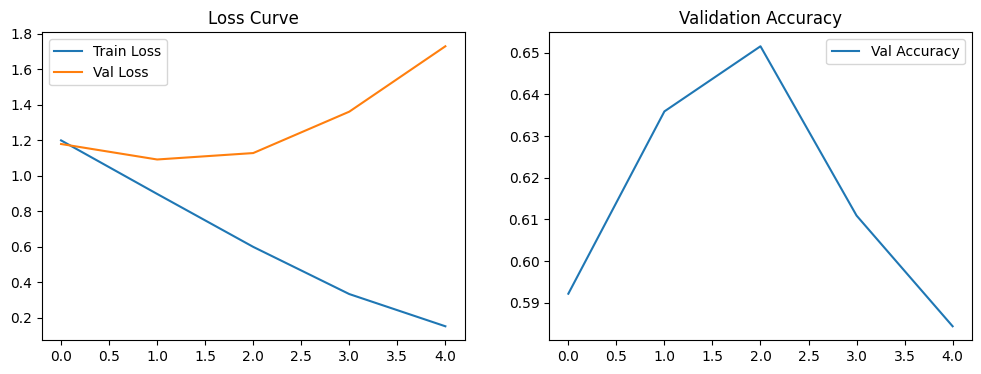

In [10]:
#  PLOT LOSS / ACCURACY
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()


Evaluating on TEST set...



Classification Report:
               precision    recall  f1-score   support

   Electronic       0.69      0.41      0.52       200
 Experimental       0.42      0.55      0.48       200
         Folk       0.91      0.35      0.51       200
      Hip-Hop       0.54      0.90      0.67       200
 Instrumental       0.68      0.52      0.59       200
International       0.64      0.81      0.72       200
          Pop       0.40      0.19      0.26       200
         Rock       0.49      0.74      0.59       200

     accuracy                           0.56      1600
    macro avg       0.60      0.56      0.54      1600
 weighted avg       0.60      0.56      0.54      1600



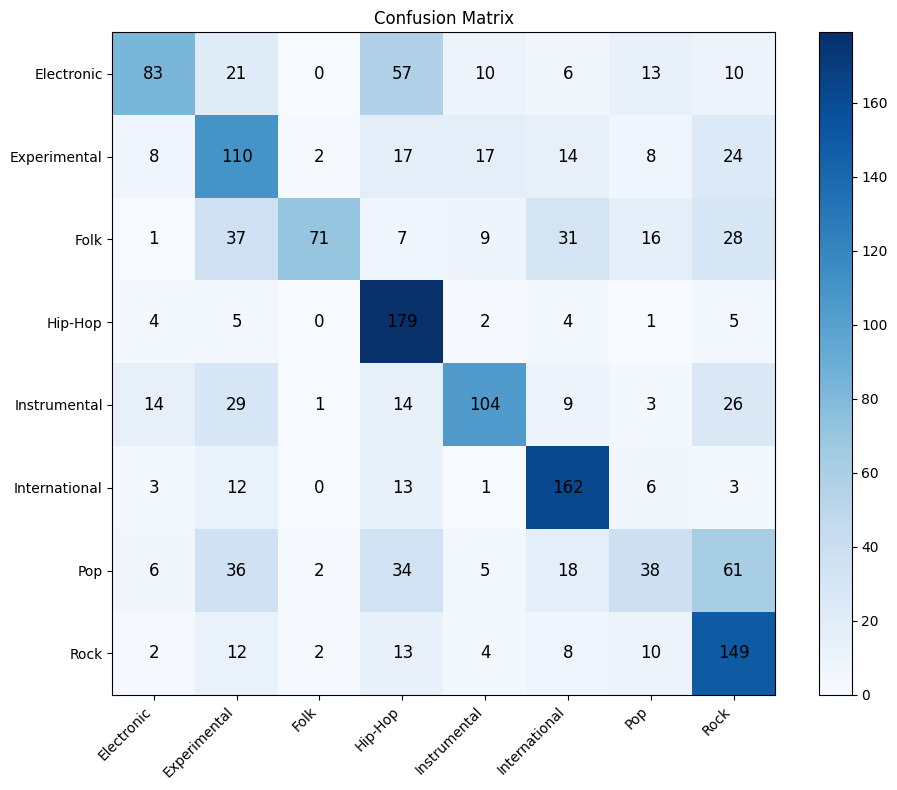

In [12]:
# TEST SET EVALUATION

print("\nEvaluating on TEST set...")

_, _, preds, labels_true = eval_epoch(model, test_loader)

print("\nClassification Report:")
print(classification_report(labels_true, preds, target_names=genre_list))

# Confusion Matrix
cm = confusion_matrix(labels_true, preds)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Axis labels
plt.xticks(range(len(genre_list)), genre_list, rotation=45, ha="right")
plt.yticks(range(len(genre_list)), genre_list)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="black", fontsize=12
        )

plt.tight_layout()
plt.show()
